In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from learning_model import *
from routerl import TrafficEnvironment
import os
from collections import deque
from routerl.keychain import Keychain as kc
from routerl.environment import generate_agents, generate_agent_data
from routerl.utilities import get_params
import pandas as pd
if "SUMO_HOME" not in os.environ:
   os.environ["SUMO_HOME"] = "No"

In [3]:
#setting
N = 10 # agents
k = 2 # paths
T = 10 # days
alpha_zero = 0.8

In [4]:
env_params = {
    "agent_parameters": {
        "num_agents": N,
        "human_parameters": {
            "model": "gawron"
        },
    }, 
    "path_generation_parameters":
        {
            "number_of_paths": k,
        }
}

env = TrafficEnvironment(seed=42, **env_params)

[CONFIRMED] Environment variable exists: SUMO_HOME
[SUCCESS] Added module directory: No/tools


In [5]:
#free_flow_travel_times = np.zeros([k,N])
env.agent_params[kc.HUMAN_PARAMETERS]['alpha_zero']=0.8

In [6]:
all_agents = generate_agents(env.agent_params, env.get_free_flow_times(), True)
agents_data_df = generate_agent_data(env.agent_params)
agents_data_df['costs'] = [agent.model.cost for agent in env.all_agents]
agents_data_df['alpha_zero'] = [agent.model.alpha_zero for agent in env.all_agents]
agents_data_df['beta'] = [agent.model.beta for agent in env.all_agents]


In [7]:
agents_data_df

,id,origin,destination,start_time,kind,costs,alpha_zero,beta
0,0,0,1,56,Human,"[1.8649459783913565, 1.8337735094037613]",0.5,-1.438114
1,1,0,1,48,Human,"[2.2530576377419216, 3.264542231579457]",0.5,-1.598700
2,2,0,1,125,Human,"[1.8649459783913565, 1.8337735094037613]",0.5,-1.438836
3,3,0,0,143,Human,"[1.8649459783913565, 1.8337735094037613]",0.5,-1.460372
4,4,1,0,125,Human,"[2.2530576377419216, 3.264542231579457]",0.5,-1.531950
5,5,0,1,141,Human,"[1.8649459783913565, 1.8337735094037613]",0.5,-1.568904
6,6,0,1,159,Human,"[1.8649459783913565, 1.8337735094037613]",0.5,-1.408557
7,7,1,0,131,Human,"[1.8649459783913565, 1.8337735094037613]",0.5,-1.532681
8,8,1,1,82,Human,"[2.2530576377419216, 3.264542231579457]",0.5,-1.581451
9,9,0,1,130,Human,"[1.7122613192145106, 1.705338550106868]",0.5,-1.580657


In [29]:
env.agent_params

{'num_agents': 10,
 'new_machines_after_mutation': 25,
 'machine_parameters': {'behavior': 'selfish',
  'observed_span': 300,
  'observation_type': 'previous_agents_plus_start_time'},
 'human_parameters': {'model': 'gawron',
  'alpha_j': 0.5,
  'alpha_zero': 0.8,
  'beta': -1.5,
  'beta_randomness': 0.1,
  'remember': 3},
 'simulation_timesteps': 180,
 'origins': ['441496282#0', '154551772#1'],
 'destinations': ['-115604057#1', '-279952229#4'],
 'action_space_size': 2,
 'records_folder': 'training_records',
 'greedy': 0}

In [202]:
def sample_cost(mean, plus=0, multiply=1, noise=0):
    return np.random.normal(1,noise)*(multiply*mean+plus)

def learning_trajectory(agent, days, reset = False, noise = 0):
    if reset:
        agent.model.costs = env.get_free_flow_times()[agent.origin,agent.destination]
    day = 1
    ret = dict()
    while day <= days:
        action = agent.act(None)
        reward = sample_cost(mean = agent.model.costs[action], plus=0, multiply=1, noise=noise)
        agent.model.learn(state = None, action = action, reward = reward)
        ret[day]={"action":action, "reward":reward, "costs":[agent.model.costs[_] for _ in [0,1]]}
        day+=1
    return pd.DataFrame(ret).T

In [149]:
from one_model import GeneralHuman, ProbabilisticModel, GawronModel


In [137]:
agent = all_agents[0]
agent.model = ProbabilisticModel(env.agent_params, env.get_free_flow_times()[agent.origin,agent.destination])

In [146]:
learning_trajectory(agent,T, reset = True)

,action,reward,costs
1,0,1.276451,"[1.2764505802320931, 1.307623049219688]"
2,0,1.276451,"[1.2764505802320931, 1.307623049219688]"
3,1,1.307623,"[1.2764505802320931, 1.307623049219688]"
4,0,1.276451,"[1.2764505802320933, 1.307623049219688]"
5,0,1.276451,"[1.2764505802320933, 1.307623049219688]"
6,0,1.276451,"[1.2764505802320933, 1.307623049219688]"
7,1,1.307623,"[1.2764505802320933, 1.307623049219688]"
8,1,1.307623,"[1.2764505802320933, 1.307623049219688]"
9,0,1.276451,"[1.2764505802320933, 1.307623049219688]"
10,0,1.276451,"[1.2764505802320933, 1.307623049219688]"


In [148]:
agent = all_agents[1]
agent.model = GawronModel(env.agent_params, initial_knowledge=[5,50])
learning_trajectory(agent,100, reset = False, noise = 0.00001)

,action,reward,costs
1,0,5.000011,"[5.000002130461264, 50.0]"
2,0,5.000007,"[5.000009963478625, 50.0]"
3,0,4.999985,"[5.000002794721793, 50.0]"
4,0,5.000013,"[4.9999907365889396, 50.0]"
5,0,4.999954,"[5.000001277669572, 50.0]"
...,...,...,...
96,0,4.999838,"[4.999787439133495, 50.0]"
97,0,4.999799,"[4.99983000996014, 50.0]"
98,0,4.999879,"[4.999814747512753, 50.0]"
99,0,4.999802,"[4.999863828620383, 50.0]"


In [205]:
agent = all_agents[2]
agent.model = WeightedModel(env.agent_params, [5,10])
df = learning_trajectory(agent,100, reset = False, noise = 0.05)
df

,action,reward,costs
1,0,5.153075,"[5.091844764232718, 10.0]"
2,0,5.340137,"[5.1923111731138665, 10.0]"
3,0,5.002078,"[5.0836375228107, 10.0]"
4,0,5.042821,"[5.0883123339540415, 10.0]"
5,0,5.164744,"[5.1225040089155085, 10.0]"
...,...,...,...
96,0,4.611397,"[4.5108925145673275, 10.0]"
97,0,4.554436,"[4.551993721837781, 10.0]"
98,0,4.89895,"[4.673843859978495, 10.0]"
99,0,4.345203,"[4.534042056447012, 10.0]"


<Axes: >

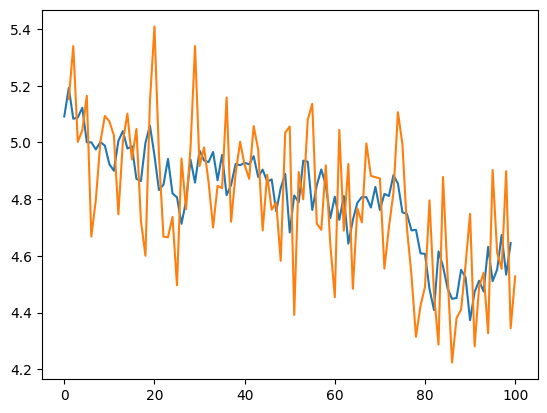

In [212]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
pd.Series([_[0] for _ in df.costs]).plot(ax = ax)
df.reward.plot(ax=ax)


In [56]:
agent.model = GeneralHuman(env.agent_params, env.get_free_flow_times()[agent.origin,agent.destination])

In [103]:
agent.model.get_noises()

[np.float64(0.0), np.float64(0.0)]

In [79]:
agent.model.act(None)

1

In [74]:

utilities = [agent.model.beta_k_i[i]* agent.model.costs[i] + noise for i,noise in enumerate(agent.model.get_noises())]
utilities

[np.float64(-1.8649459783913565), np.float64(-1.8337735094037613)]

In [87]:
agent.model.learn(state = None, action = 0, reward = 3)

In [38]:
agent.model.learn(state = None, action = agent.act(None), reward = 3)

In [34]:
agent.model.cost

array([0. , 2.4, 0. , 0. , 0. ])

In [36]:
agent.act(None)

1

In [62]:
env.agent_params[kc.BETA_RANDOMNESS]

KeyError: 'beta_randomness'

In [1]:
from one_model import *

one_model.HumanAgent